In [ ]:
import kaggle
import zipfile
from fastkaggle import *
from fastcore import *
from fastbook import *
from fastcore.all import *
import fastbook
fastbook.setup_book()
import torch
from torch.autograd import Variable
from torch import autograd
import torch.nn as nn
from torchvision import transforms

In [ ]:
#hide
!nbdev_

# torch.nn note

# Containers（容器）：

## nn.Module

一个基本的卷积网络，包含初始化和forward

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)  # submodule: Conv2d
        self.conv2 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.relu(self.conv2(x))

可见，其中包含：
- `__init__` 模型初始化方法
    - `super(Model, self).__init__()` 初始化上一层
- `forward` 前向传播

## add_module(name, module)

将一个 `child module` 添加到当前 `modle`。  
被添加的`module`可以通过 `name`属性来获取。 例：

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.add_module("conv", nn.Conv2d(10, 20, 4))

        # self.conv = nn.Conv2d(10, 20, 4) 和上面这个增加module的方式等价
model = Model()
print(model.conv)

Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1))


## children()

返回模型子模块的迭代器

In [ ]:
model = resnet18()

In [ ]:
i = 0
for sub_module in model.children():
    i += 1
    print(sub_module)
    if i == 4:
        break

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)


## cpu(device_id=None)  
将所有的模型参数(parameters)和buffers复制到CPU

In [ ]:
model = model.cpu()

## cuda(device_id=None)
将所有的模型参数(parameters)和buffers赋值GPU

参数说明:

device_id (int, optional) – 如果指定的话，所有的模型参数都会复制到指定的设备上。

In [ ]:
model = model.cuda()

## double()
将parameters和buffers的数据类型转换成double。

In [ ]:
model = model.double()

## eval()
将模型设置成evaluation模式

仅仅当模型中有Dropout和BatchNorm是才会有影响。

In [ ]:
model = model.eval()

若是在模型的非训练阶段（如 evaluation 阶段）未使用 model.eval() 将 model 设置成评估模式，有可能会造成同一样本的多次推断结果不一致的情况

## float()
将parameters和buffers的数据类型转换成float。

In [ ]:
model = model.float()

## forward(* input)
定义了每次执行的 计算步骤。 在所有的子类中都需要重写这个函数。

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)  # submodule: Conv2d
        self.conv2 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.relu(self.conv2(x))

就是这个forward

## half()
将parameters和buffers的数据类型转换成half。

In [ ]:
model = model.half()

## load_state_dict(state_dict)
将state_dict中的parameters和buffers复制到此module和它的后代中。state_dict中的key**必须**和 model.state_dict()返回的key一致。 NOTE：用来加载模型参数。

参数说明:

state_dict (dict) – 保存parameters和persistent buffers的字典。

In [ ]:
model = resnet18()

In [ ]:
model.load_state_dict(resnet18().state_dict())

<All keys matched successfully>

## modules()
返回一个包含 当前模型 所有模块的迭代器。

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.add_module("conv", nn.Conv2d(10, 20, 4))
        self.add_module("conv1", nn.Conv2d(20, 10, 4))


model = Model()

In [ ]:
for module in model.modules():
    print(module)
    print('-------------CUTTHERE---------------')

Model(
  (conv): Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1))
  (conv1): Conv2d(20, 10, kernel_size=(4, 4), stride=(1, 1))
)
-------------CUTTHERE---------------
Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1))
-------------CUTTHERE---------------
Conv2d(20, 10, kernel_size=(4, 4), stride=(1, 1))
-------------CUTTHERE---------------


可以看见，它输出了所有的模块

重复的模块只被返回一次(children()也是)

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        submodule = nn.Conv2d(10, 20, 4)
        self.add_module('conv1', submodule)
        self.add_module('cv2', submodule)
        self.add_module('cv20', submodule)

In [ ]:
model = Model()

In [ ]:
for module in model.modules():
    print(module)
    print('-------------CUTTHERE---------------')

Model(
  (conv1): Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1))
  (cv2): Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1))
  (cv20): Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1))
)
-------------CUTTHERE---------------
Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1))
-------------CUTTHERE---------------


## named_children()
返回 包含 模型当前子模块 的迭代器，yield 模块名字和模块本身。

In [ ]:
for name, module in model.named_children():
    # if name in ['conv4', 'conv5']:
    print(name, module)

conv1 Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1))


## parameters(memo=None)
返回一个 包含模型所有参数 的迭代器。

一般用来当作`optimizer`的参数。

In [ ]:
model = Model()

In [ ]:
for i in model.parameters():
    print(type(i.data), i.size())

<class 'torch.Tensor'> torch.Size([20, 10, 4, 4])
<class 'torch.Tensor'> torch.Size([20])


## state_dict(destination=None, prefix='')[source]
返回一个字典，保存着module的所有状态（state）。

parameters和persistent buffers都会包含在字典中，字典的key就是parameter和buffer的 names。

例子：

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv2 = nn.Linear(1, 2)
        self.vari = Variable(torch.rand([1]))
        self.par = nn.Parameter(torch.rand([1]))
        self.register_buffer("buffer", torch.randn([2, 3]))

    def forward(self, x):
        x = self.conv2(x)
        return x


model = Model()
print(model.state_dict())  # .keys())

OrderedDict([('par', tensor([0.4542])), ('buffer', tensor([[ 2.1136,  0.1283,  0.4152],
        [ 1.4492, -0.8829,  0.0859]])), ('conv2.weight', tensor([[-0.0936],
        [ 0.7408]])), ('conv2.bias', tensor([-0.8880, -0.3095]))])


NOTE：`.keys()`:显示`OrderedDict`的key

In [ ]:
print(model.state_dict().keys())

odict_keys(['par', 'buffer', 'conv2.weight', 'conv2.bias'])


## train(mode=True)
将module设置为 training mode。

仅仅当模型中有Dropout和BatchNorm是才会有影响。

## zero_grad()
将module中的所有模型参数的梯度设置为0.

In [ ]:
model.zero_grad()

## class torch.nn.Sequential(* args)

一个时序容器。`Modules` 会以他们传入的顺序被添加到容器中。当然，也可以传入一个`OrderedDict`。

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 20, 5),
    nn.ReLU(),
    nn.Conv2d(20, 64, 5),
    nn.ReLU()
)
# Example of using Sequential with OrderedDict
model = nn.Sequential(OrderedDict([
    ('conv1', nn.Conv2d(1, 20, 5)),
    ('relu1', nn.ReLU()),
    ('conv2', nn.Conv2d(20, 64, 5)),
    ('relu2', nn.ReLU())
]))

In [ ]:
model

Sequential(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(20, 64, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
)

## class torch.nn.ModuleList(modules=None)

将`submodules`保存在一个`list`中。

`ModuleList`可以像一般的Python `list`一样被索引。而且`ModuleList`中包含的`modules`已经被正确的注册，对所有的`module method`可见。

In [ ]:
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.linears = nn.ModuleList([nn.Linear(10, 10) for i in range(10)])

    def forward(self, x):
        # ModuleList can act as an iterable, or be indexed         using ints
        for i, l in enumerate(self.linears):
            x = self.linears[i // 2](x) + l(x)
        return x

In [ ]:
model = MyModule()

In [ ]:
for module in model.modules():
    print(module)
    print('-------------CUTTHERE---------------')

MyModule(
  (linears): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): Linear(in_features=10, out_features=10, bias=True)
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): Linear(in_features=10, out_features=10, bias=True)
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): Linear(in_features=10, out_features=10, bias=True)
  )
)
-------------CUTTHERE---------------
ModuleList(
  (0): Linear(in_features=10, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): Linear(in_features=10, out_features=10, bias=True)
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): Linear(in_fea

## append(module)

等价于 `list` 的 `append()`

参数说明:

module (nn.Module) – 要 append 的module

In [ ]:
list0.append(nn.Linear(1, 10))

ModuleList(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=1, out_features=10, bias=True)
  (2): Linear(in_features=1, out_features=10, bias=True)
  (3): Linear(in_features=1, out_features=10, bias=True)
  (4): Linear(in_features=1, out_features=10, bias=True)
  (5): Linear(in_features=1, out_features=10, bias=True)
  (6): Linear(in_features=1, out_features=10, bias=True)
  (7): Linear(in_features=1, out_features=10, bias=True)
  (8): Linear(in_features=1, out_features=10, bias=True)
)

## extend(modules)

等价于 `list` 的 `extend()` 方法

参数说明:

modules (list) – list of modules to append

In [ ]:
list0 = nn.ModuleList([nn.Linear(1, 10)])

In [ ]:
list0

ModuleList(
  (0): Linear(in_features=1, out_features=10, bias=True)
)

In [ ]:
list0.extend([nn.Linear(1, 10), nn.Linear(1, 10)])

ModuleList(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=1, out_features=10, bias=True)
  (2): Linear(in_features=1, out_features=10, bias=True)
)

extend输入迭代器/列表等，append输入一个数据

# 卷积层

## class torch.nn.Conv1d

- in_channels(int) 
    - 输入信号的通道(比如RGB)
- out_channels(int) 
    - 卷积产生的通道（比如六个通道）
- kerner_size(int or tuple) 
    - 卷积核的尺寸
- stride(int or tuple, optional) 
    - 卷积步长（用来节省计算量）
- padding (int or tuple, optional)
    - 输入的每一条边补充0的层数（补充边缘）
- dilation(int or tuple, `optional``) 
    - 卷积核元素之间的间距（空洞卷积）
- groups(int, optional)  
    - 从输入通道到输出通道的阻塞连接数（控制输入和输出之间的连接， group=1，输出是所有的输入的卷积；group=2，此时相当于有并排的两个卷积层，每个卷积层计算输入通道的一半，并且产生的输出是输出通道的一半，随后将这两个输出连接起来。）
- bias(bool, optional) - 如果bias=True，添加偏置

In [ ]:
m = nn.Conv1d(16, 33, 3, stride=2)
input0 = torch.autograd.Variable(torch.randn(1, 16, 3))
output = m(input0)

注意：对于一组图片，会产生一组输出

图片叠加在第一维度

比如`torch.randn(10, 16, 3)`在这里相当于十张大小为长3通道16的图片

In [ ]:
output.size()

torch.Size([1, 33, 1])

`nn.Conv2d,3d`同理，只有卷积核尺寸不同

## class torch.nn.ConvTranspose1d

1维的解卷积（转置卷积）操作（transposed convolution operator，注意改视作操作可视作解卷积操作，但并不是真正的解卷积操作） 该模块可以看作是Conv1d相对于其输入的梯度，有时（但不正确地）被称为解卷积操作。

很显然，它会丢失信息，并且会产生棋盘格伪影

输入：  
class torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True)

- in_channels(int) – 输入信号的通道数
- out_channels(int) – 卷积产生的通道
- kernel_size(int or tuple) - 卷积核的大小
- stride(int or tuple, optional) - 卷积步长
- padding(int or tuple, optional) - 输入的每一条边补充0的层数
- output_padding(int or tuple, optional) - 输出的每一条边补充0的层数
- dilation(int or tuple, optional) – 卷积核元素之间的间距
- groups(int, optional) – 从输入通道到输出通道的阻塞连接数
- bias(bool, optional) - 如果bias=True，添加偏置

In [ ]:
im = PILImage.create(imgpath[0])

In [ ]:
data = untar_data(URLs.PETS)

imgpath = get_image_files(data/'images')

img = ToTensor()(PILImage.create(imgpath[0]))

img = img.float()

img = img.unsqueeze(0)

创建一个卷积核

<matplotlib.image.AxesImage>

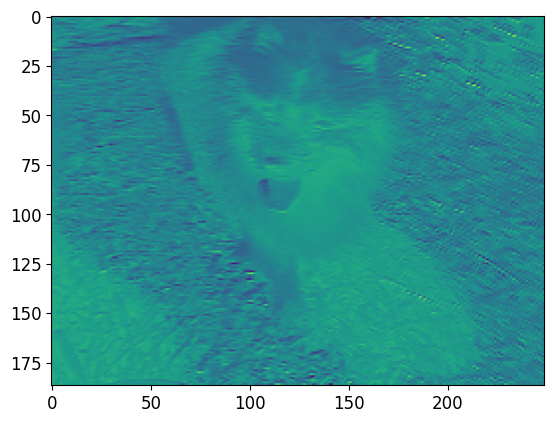

In [ ]:
conv = nn.Conv2d(3, 1, 3, 2)

imgc = conv(img)

imga = array(imgc.detach())

plt.imshow(imga[0][0])

转置卷积

In [ ]:
convt = nn.ConvTranspose2d(1, 3, 3, 2)

In [ ]:
imgc.size()

torch.Size([1, 1, 187, 249])

In [ ]:
imgc[0].size()

torch.Size([1, 187, 249])

In [ ]:
imgt = convt(imgc[0])

In [ ]:
imgt = imgt*255

In [ ]:
imgt = imgt.int()

In [ ]:
imgt = array(imgt.detach())

In [ ]:
tim = transforms.ToPILImage()

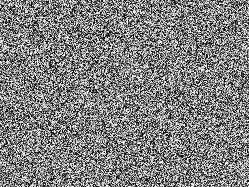

In [ ]:
tim(imgc[0])

正常来说用不到这个）

# 池化层

## nn.MaxPool1d

最大池化

- kernel_size(int or tuple) - max pooling的窗口大小
- stride(int or tuple, optional) - max pooling的窗口移动的步长。默认值是kernel_size
- padding(int or tuple, optional) - 输入的每一条边补充0的层数
- dilation(int or tuple, optional) – 一个控制窗口中元素步幅的参数
- return_indices - 如果等于True，会返回输出最大值的序号，对于上采样操作会有帮助
- ceil_mode - 如果等于True，计算输出信号大小的时候，会使用向上取整，代替默认的向下取整的操作

## nn.AvgPool1d

平均池化

## nn.FractionalMaxPool2d

分数最大化池化

- kernel_size(int or tuple) - 最大池化操作时的窗口大小。可以是一个数字（表示K*K的窗口），也可以是一个元组（kh*kw）
- output_size - 输出图像的尺寸。可以使用一个tuple指定(oH,oW)，也可以使用一个数字oH指定一个oH*oH的输出。
- output_ratio – 将输入图像的大小的百分比指定为输出图片的大小，使用一个范围在(0,1)之间的数字指定
- return_indices - 默认值False，如果设置为True，会返回输出的索引，索引对 nn.MaxUnpool2d有用。

也就是说，它可以对任意大小的东西进行最大池化，并输出相同/相同比例大小的图片

有点像最近邻采样

## nn.LPPool2d

二维幂平均池化

也就是一个结合了最大池化和平均池化的方法

`m = nn.LPPool2d(p, (3, 2), stride=(2, 1))`  
- 当p为无穷大的时候时，等价于最大池化操作
- 当p=1时，等价于平均池化操作

## nn.AdaptiveMaxPool2d

自适应最大池化

- output_size: 输出信号的尺寸,可以用（H,W）表示H*W的输出，也可以使用数字H表示H*H大小的输出
- return_indices: 如果设置为True，会返回输出的索引。对 nn.MaxUnpool2d有用，默认值是False

# Non-Linear Activations 非线性激活函数

激活函数是用来增加网络非线性的

常用的有`relu`,`sigmoid`,`softmax`

## torch.nn.ReLU

线性整流单元(也就是把小于零的变成0）  
${ReLU}(x)= max(0, x)$

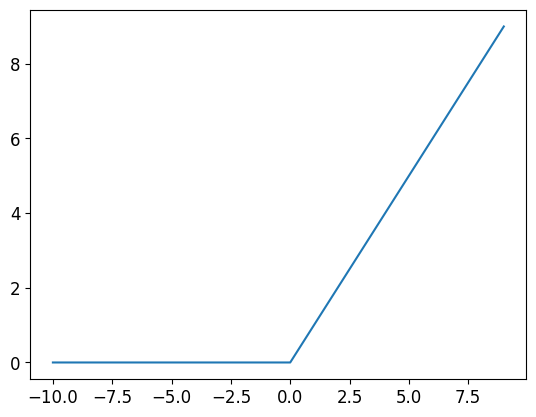

In [ ]:
x = torch.arange(-10, 10)
y = nn.ReLU()(x)

plt.plot(x, y);

## nn.ReLU6

对输入的每一个元素运用函数  
${ReLU6}(x) = min(max(0,x), 6)$

也就是把小于0的变成0,大于6的变成6

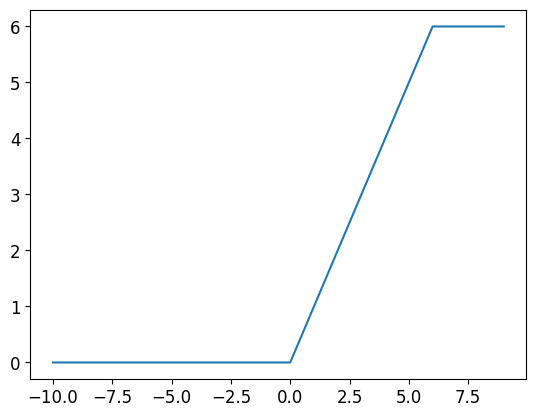

In [ ]:
x = torch.arange(-10, 10)
y = nn.ReLU6()(x)

plt.plot(x, y);

## nn.ELU

对输入的每一个元素运用函数  
$f(x) = max(0,x) + min(0, alpha * (e^x - 1))$

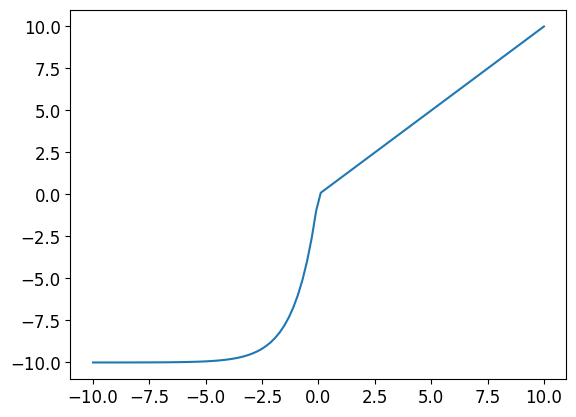

In [ ]:
x = torch.linspace(-10, 10, 100)
y = nn.ELU(10)(x)

plt.plot(x, y);

也就是对于0以下的，使用e*\*x，对于0以上的，使用普通的ReLU

## nn.PReLU

对输入的每一个元素运用函数$PReLU(x) = max(0,x) + a * min(0,x)$

a是一个可学习参数。当没有声明时，nn.PReLU()在所有的输入中只有一个参数a；如果是nn.PReLU(nChannels)，a将应用到每个输入。

- num_parameters=1 -需要学习的a的个数  
- init=0.25 -a的默认值

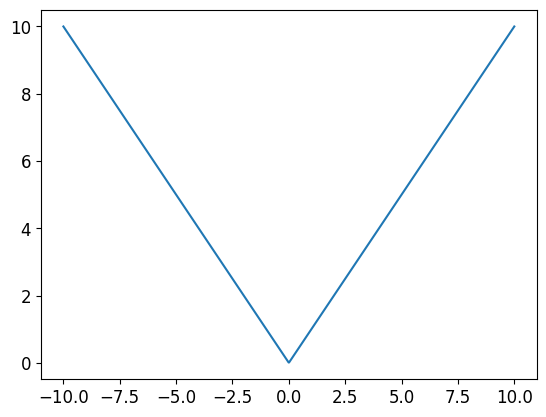

In [ ]:
x = torch.linspace(-10, 10, 1000)
y = nn.PReLU(num_parameters=1, init=-1)(x).detach().numpy()


plt.plot(x, y);

也就是说，这是一个在负值上进行y=ax，正值进行y=x的函数

不要对a使用权重衰减

## nn.LeakyReLU

- negative_slope：控制负斜率的角度，默认等于0.01
- inplace-选择是否进行覆盖运算

对输入的每一个元素运用$f(x) = max(0, x) + {negative_slope} * min(0, x)$

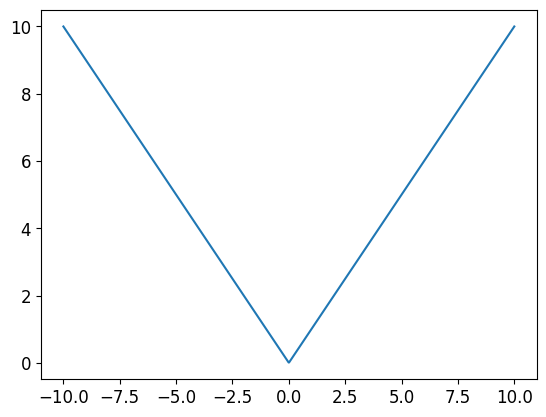

In [ ]:
x = torch.linspace(-10, 10, 1000)
y = nn.LeakyReLU(-1)(x).detach().numpy()


plt.plot(x, y);

与PReLU差不多，但是a固定

## nn.Threshold

- threshold：阈值
- value：输入值小于阈值则会被value代替
- inplace：选择是否进行覆盖运算

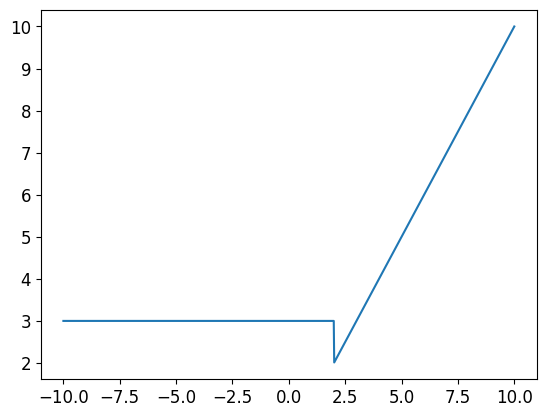

In [ ]:
x = torch.linspace(-10, 10, 1000)
y = nn.Threshold(threshold=2, value=3)(x).detach().numpy()


plt.plot(x, y);

相当于ReLU的泛化

## nn.Hardtanh

- min_val：线性区域范围最小值
- max_val：线性区域范围最大值
- inplace：选择是否进行覆盖运算

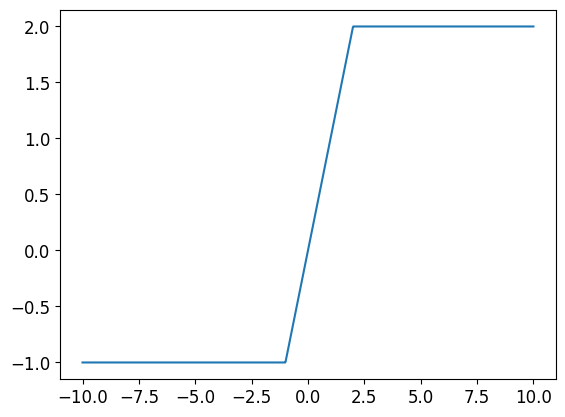

In [ ]:
x = torch.linspace(-10, 10, 1000)
y = nn.Hardtanh(min_val=-1, max_val=2)(x).detach().numpy()


plt.plot(x, y);

虽然带有`tanh`,但和tan没什么关系。它就相当于`ReLU6`的泛化

## nn.Sigmoid 

$$f ( x ) = 1 / ( 1 + e − x )$$

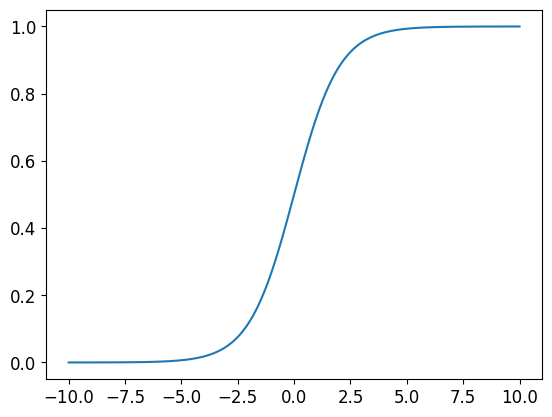

In [ ]:
x = torch.linspace(-10, 10, 1000)
y = nn.Sigmoid()(x).detach().numpy()


plt.plot(x, y);

## nn.Tanh

$$f ( x ) = (e^x − e^x) / (e^x + e^x)$$

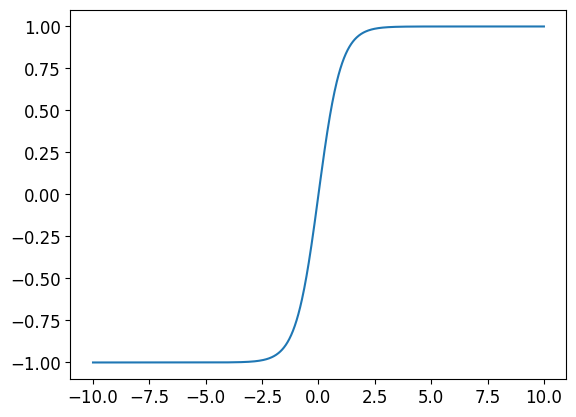

In [ ]:
x = torch.linspace(-10, 10, 1000)
y = nn.Tanh()(x).detach().numpy()


plt.plot(x, y);

其实和sigmoid挺像的，不过更窄一点

## nn.LogSigmoid

$$LogSigmoid(x) = log( 1 / ( 1 + e^{-x}))$$

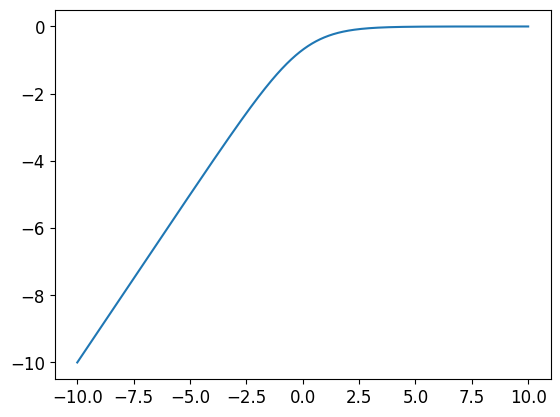

In [ ]:
x = torch.linspace(-10, 10, 1000)
y = nn.LogSigmoid()(x).detach().numpy()


plt.plot(x, y);

也就是`sigmoid`的对数

## nn.Softplus

$$f ( x ) = \frac{1}{beta}∗log(1+e(beta∗xi))$$

- beta：Softplus函数的beta值(默认为1)
- threshold：阈值(i)(默认为20）

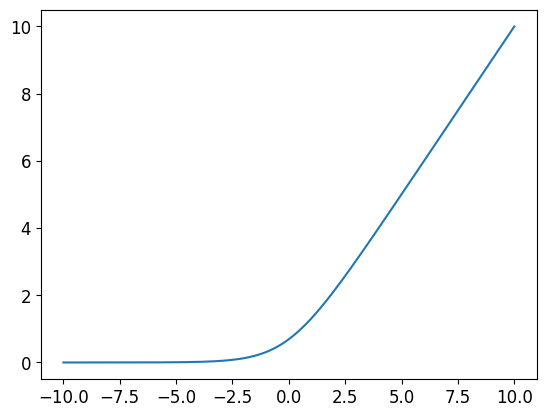

In [ ]:
x = torch.linspace(-10, 10, 1000)
y = nn.Softplus(beta=1, threshold=20)(x).detach().numpy()


plt.plot(x, y);

`Softplus`函数是`ReLU`函数的平滑逼近

## nn.Softshrink

$$f ( x ) = x − lambda , if x > lambda f ( x ) = x + lambda , if x < −lambda f(x)=0,otherwise$$

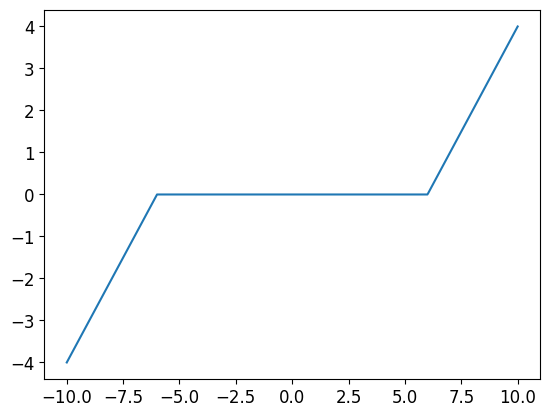

In [ ]:
x = torch.linspace(-10, 10, 1000)
y = nn.Softshrink(lambd=6)(x).detach().numpy()


plt.plot(x, y);

如你所见，中间的台阶大小是12

## nn.Softsign

$$f(x) = x / (1 + |x|)$$

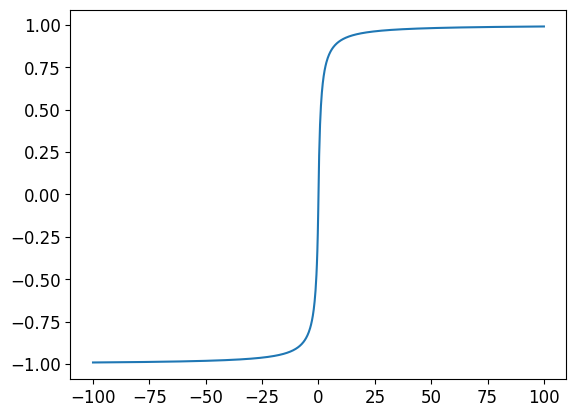

In [ ]:
x = torch.linspace(-100, 100, 1000)
y = nn.Softsign()(x).detach().numpy()


plt.plot(x, y);

## nn.Tanhshrink

$$Tanhshrink ( x ) = x − Tanh ( x )$$

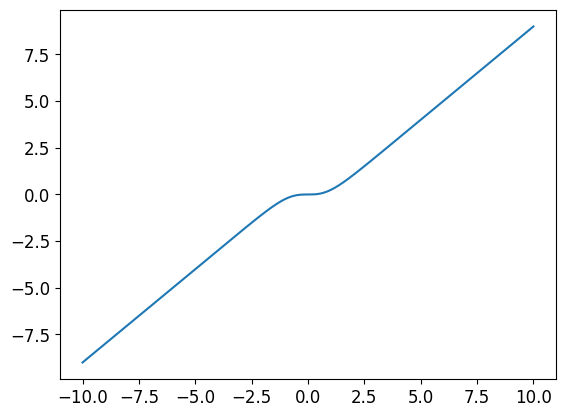

In [ ]:
x = torch.linspace(-10, 10, 1000)
y = nn.Tanhshrink()(x).detach().numpy()


plt.plot(x, y);

## nn.Softmin

它对n维输入张量运用Softmin函数，将张量的每个元素缩放到（0,1）区间且和为1。

In [ ]:
m = nn.Softmin(dim=0)
input0 = torch.autograd.Variable(torch.arange(0, 20).reshape(5, 4).float())
print(input0)
print(m(input0))

tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.],
        [16., 17., 18., 19.]])
tensor([[9.8168e-01, 9.8168e-01, 9.8168e-01, 9.8168e-01],
        [1.7980e-02, 1.7980e-02, 1.7980e-02, 1.7980e-02],
        [3.2932e-04, 3.2932e-04, 3.2932e-04, 3.2932e-04],
        [6.0317e-06, 6.0317e-06, 6.0317e-06, 6.0317e-06],
        [1.1047e-07, 1.1047e-07, 1.1047e-07, 1.1047e-07]])


## nn.Softmax

和`Softmin`”相反“

In [ ]:
m = nn.Softmax(dim=0)
input0 = torch.autograd.Variable(torch.arange(0, 20).reshape(5, 4).float())
print(input0)
print(m(input0))

tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.],
        [16., 17., 18., 19.]])
tensor([[1.1047e-07, 1.1047e-07, 1.1047e-07, 1.1047e-07],
        [6.0317e-06, 6.0317e-06, 6.0317e-06, 6.0317e-06],
        [3.2932e-04, 3.2932e-04, 3.2932e-04, 3.2932e-04],
        [1.7980e-02, 1.7980e-02, 1.7980e-02, 1.7980e-02],
        [9.8168e-01, 9.8168e-01, 9.8168e-01, 9.8168e-01]])


## nn.LogSoftmax

In [ ]:
m = nn.LogSoftmax(dim=0)
input0 = torch.autograd.Variable(torch.arange(0, 20).reshape(5, 4).float())
print(input0)
print(m(input0))

tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.],
        [16., 17., 18., 19.]])
tensor([[-16.0185, -16.0185, -16.0185, -16.0185],
        [-12.0185, -12.0185, -12.0185, -12.0185],
        [ -8.0185,  -8.0185,  -8.0185,  -8.0185],
        [ -4.0185,  -4.0185,  -4.0185,  -4.0185],
        [ -0.0185,  -0.0185,  -0.0185,  -0.0185]])


# Normalization layers 标准化层

## nn.BatchNorm2d

*num_features, eps=1e-05, momentum=0.1, affine=True*

对小批量(mini-batch)3d数据组成的4d输入进行批标准化(Batch Normalization)操作

- num_features： 来自期望输入的特征数，该期望输入的大小为'batch_size x num_features x height x width'
- eps： 为保证数值稳定性（分母不能趋近或取0）,给分母加上的值。默认为1e-5。
- momentum： 动态均值和动态方差所使用的动量。默认为0.1。
- affine： 一个布尔值，当设为true，给该层添加可学习的仿射变换参数。

In [ ]:
# With Learnable Parameters
m = nn.BatchNorm2d(100)

In [ ]:
# Without Learnable Parameters
m = nn.BatchNorm2d(100, affine=False)

In [ ]:
input0 = torch.autograd.Variable(torch.rand(20, 100, 35, 45))
mean = input0.mean()
std = input0.var()
print(std, var)
input0 = m(input0)
mean = input0.mean()
std = input0.var()
print(std, var)

tensor(0.0833) tensor(0.9999, grad_fn=<VarBackward0>)
tensor(0.9999, grad_fn=<VarBackward0>) tensor(0.9999, grad_fn=<VarBackward0>)


也就是把平均值变成1,标准差变成1

# Recurrent layers 循环层

恭喜你看到了这里！这里是循环神经网络（RNN）

## nn.RNN(args, *kwargs)

*这只是一个几层全连接和激活函数组成的简单RNN而已……*  
*它是层啊……那没事了*

将一个多层的 `Elman RNN`，激活函数为`tanh`或者`ReLU`，用于输入序列。

对输入序列中每个元素，RNN每层的计算公式为 $$ h_t=tanh(w_{ih} x_t+b_{ih}+w_{hh} h_{t-1}+b_{hh}) $$ $h_t$是时刻$t$的隐状态。 $x_t$是上一层时刻$t$的隐状态，或者是第一层在时刻$t$的输入。如果nonlinearity='relu',那么将使用relu代替tanh作为激活函数。

### 参数

- input_size – 输入x的特征数量。

- hidden_size – 隐层的特征数量。

- num_layers – RNN的层数。

- nonlinearity – 指定非线性函数使用tanh还是relu。默认是tanh。

- bias – 如果是False，那么RNN层就不会使用偏置权重 $b_ih$和$b_hh$,默认是True

- batch_first – 如果True的话，那么输入Tensor的shape应该是[batch_size, time_step, feature],输出也是这样。

- dropout – 如果值非零，那么除了最后一层外，其它层的输出都会套上一个dropout层。

- bidirectional – 如果True，将会变成一个双向RNN，默认为False。

### 输入 (input, h_0)

input(seq_len, batch, input_size): 保存输入序列特征的`tensor`。

`input`可以是被填充的变长的序列。细节请看`torch.nn.utils.rnn.pack_padded_sequence()`

- h_0(num_layers * num_directions, batch, hidden_size): 保存着初始隐状态的tensor

### 输出 (output, h_n)

- output (seq_len, batch, hidden_size * num_directions): 保存着RNN最后一层的输出特征。如果输入是被填充过的序列，那么输出也是被填充的序列。
- h_n (num_layers * num_directions, batch, hidden_size): 保存着最后一个时刻隐状态。

### 属性

- weight_ih_l[k] – 第k层的 input-hidden 权重， 可学习，形状是(input_size x hidden_size)。

- weight_hh_l[k] – 第k层的 hidden-hidden 权重， 可学习，形状是(hidden_size x hidden_size)

- bias_ih_l[k] – 第k层的 input-hidden 偏置， 可学习，形状是(hidden_size)

- bias_hh_l[k] – 第k层的 hidden-hidden 偏置， 可学习，形状是(hidden_size)

### 示例

建立一个RNN

In [ ]:
#rnn = nn.RNN(10, 30, 1)

In [ ]:
rnn = nn.RNN(1, 1, 1)

生成假数据：

input0为时间序列  
h0为第一份输入

In [ ]:
input0 = Variable(torch.arange(0, 100).reshape(100, 1, -1).float())

h0 = input0[0]

网络的内容

In [ ]:
rnn.zero_grad()
for i in rnn.parameters():
    print(i.grad)
    #i.data.add_(-1, i.grad.data)

tensor([[0.]])
tensor([[0.]])
tensor([0.])
tensor([0.])


In [ ]:
output, hn = rnn(input0[1], h0)

In [ ]:
output

tensor([[-1.0000]], grad_fn=<SqueezeBackward1>)

In [ ]:
input0[1]

tensor([[1.]])

In [ ]:
hn

tensor([[-0.4810]], grad_fn=<SqueezeBackward1>)

## nn.LSTM

*长短期记忆*

将一个多层的 (LSTM) 应用到输入序列。

对输入序列的每个元素，LSTM的每层都会执行以下计算： 

$$ \begin{aligned} i_t &= sigmoid(W_{ii}x_t+b_{ii}+W_{hi}h_{t-1}+b_{hi}) \ f_t &= sigmoid(W_{if}x_t+b_{if}+W_{hf}h_{t-1}+b_{hf}) \ o_t &= sigmoid(W_{io}x_t+b_{io}+W_{ho}h_{t-1}+b_{ho})\ g_t &= tanh(W_{ig}x_t+b_{ig}+W_{hg}h_{t-1}+b_{hg})\ c_t &= f_tc_{t-1}+i_tg_t\ h_t &= o_t*tanh(c_t) \end{aligned} $$ 

$h_t$是时刻$t$的隐状态,$c_t$是时刻$t$的细胞状态，$x_t$是上一层的在时刻$t$的隐状态或者是第一层在时刻$t$的输入。$i_t, f_t, g_t, o_t$ 分别代表 输入门，遗忘门，细胞和输出门。

*其实这东西不看也没什么关系的*

### 参数

- input_size – 输入的特征维度

- hidden_size – 隐状态的特征维度

- num_layers – 层数（和时序展开要区分开）

- bias – 如果为False，那么LSTM将不会使用$b_{ih},b_{hh}$，默认为True。

- batch_first – 如果为True，那么输入和输出Tensor的形状为(batch, seq, feature)

- dropout – 如果非零的话，将会在RNN的输出上加个dropout，最后一层除外。

- bidirectional – 如果为True，将会变成一个双向RNN，默认为False。

### 输入: input, (h_0, c_0)

- input (seq_len, batch, input_size): 包含输入序列特征的Tensor。也可以是packed variable。

- h_0 (num_layers * num_directions, batch, hidden_size):保存着batch中每个元素的初始化隐状态的Tensor

- c_0 (num_layers * num_directions, batch, hidden_size): 保存着batch中每个元素的初始化细胞状态的Tensor

### 输出:output, (h_n, c_n)

- output (seq_len, batch, hidden_size * num_directions): 保存RNN最后一层的输出的Tensor。 如果输入是torch.nn.utils.rnn.PackedSequence，那么输出也是torch.nn.utils.rnn.PackedSequence。

- h_n (num_layers * num_directions, batch, hidden_size): Tensor，保存着RNN最后一个时间步的隐状态。

- c_n (num_layers * num_directions, batch, hidden_size): Tensor，保存着RNN最后一个时间步的细胞状态。

### 属性

- weight_ih_l[k] – 第k层可学习的input-hidden权重($W_{ii}|W_{if}|W_{ig}|W_{io}$)，形状为(input_size x 4*hidden_size)

- weight_hh_l[k] – 第k层可学习的hidden-hidden权重($W_{hi}|W_{hf}|W_{hg}|W_{ho}$)，形状为(hidden_size x 4*hidden_size)。

- bias_ih_l[k] – 第k层可学习的input-hidden偏置($b_{ii}|b_{if}|b_{ig}|b_{io}$)，形状为( 4*hidden_size)

- bias_hh_l[k] – 第k层可学习的hidden-hidden偏置($b_{hi}|b_{hf}|b_{hg}|b_{ho}$)，形状为( 4*hidden_size)。

In [ ]:
lstm = nn.LSTM(10, 20, 2)
input0 = Variable(torch.randn(5, 3, 10))
h0 = Variable(torch.randn(2, 3, 20))
c0 = Variable(torch.randn(2, 3, 20))
output, hn = lstm(input0, (h0, c0))

In [ ]:
output.size()

torch.Size([5, 3, 20])

In [ ]:
hn[0].size()

torch.Size([2, 3, 20])

## nn.GRU

*与LSTM相比，GRU内部少了一个”门控“，参数比LSTM少，但是却也能够达到与LSTM相当的功能。*

将一个多层的GRU用于输入序列。

对输入序列中的每个元素，每层进行了一下计算：

$$ \begin{aligned} r_t&=sigmoid(W_{ir}x_t+b_{ir}+W_{hr}h_{(t-1)}+b_{hr})\ i_t&=sigmoid(W_{ii}x_t+b_{ii}+W_{hi}h_{(t-1)}+b_{hi})\ n_t&=tanh(W_{in}x_t+b_{in}+rt(W_{hn}h_{(t-1)}+b_{hn}))\ h_t&=(1-i_t) nt+i_t*h(t-1) \end{aligned} $$ $h_t$是是时间$t$的上的隐状态，$x_t$是前一层$t$时刻的隐状态或者是第一层的$t$时刻的输入，$r_t, i_t, n_t$分别是重置门，输入门和新门。

### 示例：

In [ ]:
rnn = nn.GRU(10, 20, 2)
input0 = Variable(torch.randn(5, 3, 10))
h0 = Variable(torch.randn(2, 3, 20))
output, hn = rnn(input0, h0)

In [ ]:
output.size()

torch.Size([5, 3, 20])

In [ ]:
hn.size()

torch.Size([2, 3, 20])

## nn.RNNCell

将一个多层的 `Elman RNNCell`，激活函数为`tanh`或者`ReLU`，应用于输入序列。公式： $$ h'=tanh(w_{ih} x+b_{ih}+w_{hh} h+b_{hh}) $$ 如果nonlinearity=relu，那么将会使用ReLU来代替tanh。

### 参数

- input_size – 输入$x$，特征的维度。

- hidden_size – 隐状态特征的维度。

- bias – 如果为False，RNN cell中将不会加入bias，默认为True。

- nonlinearity – 用于选择非线性激活函数 [tanh|relu]. 默认值为： tanh

### 输入： input, hidden

- input (batch, input_size): 包含输入特征的tensor。

- hidden (batch, hidden_size): 保存着初始隐状态值的tensor。

### 输出： h’

- h’ (batch, hidden_size):下一个时刻的隐状态。

### 属性：

- weight_ih – input-hidden 权重， 可学习，形状是(input_size x hidden_size)。

- weight_hh – hidden-hidden 权重， 可学习，形状是(hidden_size x hidden_size)

- bias_ih – input-hidden 偏置， 可学习，形状是(hidden_size)

- bias_hh – hidden-hidden 偏置， 可学习，形状是(hidden_size)

### 示例

初始化一个（10,20）的rnncell（类似全连接层）

In [ ]:
rnn = nn.RNNCell(10, 20)

生成随机数据

In [ ]:
input0 = Variable(torch.randn(6, 3, 10))
hx = Variable(torch.randn(3, 20))
output = []

进行预测

In [ ]:
for i in range(6):
    hx = rnn(input0[i], hx)
    output.append(hx)

In [ ]:
len(output)

6

## nn.LSTMCell

公式：

$$ \begin{aligned} i &= sigmoid(W_{ii}x+b_{ii}+W_{hi}h+b_{hi}) \ f &= sigmoid(W_{if}x+b_{if}+W_{hf}h+b_{hf}) \ o &= sigmoid(W_{io}x+b_{io}+W_{ho}h+b_{ho})\ g &= tanh(W_{ig}x+b_{ig}+W_{hg}h+b_{hg})\ c' &= f_tc_{t-1}+i_tg_t\ h' &= o_t*tanh(c') \end{aligned} $$

### 参数

- input_size – 输入的特征维度。
- hdden_size – 隐状态的维度。
- bias – 如果为False，那么将不会使用bias。默认为True。

### 输入: input, (h_0, c_0)

- input (seq_len, batch, input_size): 包含输入序列特征的Tensor。也可以是packed variable

- h_0 ( batch, hidden_size):保存着batch中每个元素的初始化隐状态的Tensor

- c_0 (batch, hidden_size): 保存着batch中每个元素的初始化细胞状态的Tensor

### 输出： h_1, c_1

- h_1 (batch, hidden_size): 下一个时刻的隐状态。
- c_1 (batch, hidden_size): 下一个时刻的细胞状态。

### 属性:

- weight_ih – input-hidden权重($W_{ii}|W_{if}|W_{ig}|W_{io}$)，形状为(input_size x 4*hidden_size)

- weight_hh – hidden-hidden权重($W_{hi}|W_{hf}|W_{hg}|W_{ho}$)，形状为(hidden_size x 4*hidden_size)。

- bias_ih – input-hidden偏置($b_{ii}|b_{if}|b_{ig}|b_{io}$)，形状为( 4*hidden_size)

- bias_hh – hidden-hidden偏置($b_{hi}|b_{hf}|b_{hg}|b_{ho}$)，形状为( 4*hidden_size)。

### 例子

In [ ]:
rnn = nn.LSTMCell(10, 20)
input0 = Variable(torch.randn(6, 3, 10))
hx = Variable(torch.randn(3, 20))
cx = Variable(torch.randn(3, 20))
output = []
for i in range(6):
    hx, cx = rnn(input0[i], (hx, cx))
    output.append(hx)

## nn.GRUCell

同上

In [ ]:
rnn = nn.GRUCell(10, 20)
input0 = Variable(torch.randn(6, 3, 10))
hx = Variable(torch.randn(3, 20))
output = []
for i in range(6):
    hx = rnn(input0[i], hx)
    output.append(hx)

# Linear layers 线性层

## nn.Linear(in_features, out_features, bias=True)

对输入数据做线性变换：$y = Ax + b$

### 参数：

- in_features - 每个输入样本的大小
- out_features - 每个输出样本的大小
- bias - 若设置为False，这层不会学习偏置。默认值：True

### 形状：

- 输入: (N,in_features)
- 输出： (N,out_features)

### 属性：

- weight -形状为(out_features x in_features)的模块中可学习的权值
- bias -形状为(out_features)的模块中可学习的偏置

In [ ]:
m = nn.Linear(20, 30)
input0 = torch.autograd.Variable(torch.randn(128, 20))
output = m(input0)
print(output.size())

torch.Size([128, 30])


# Dropout layers 丢弃层

## nn.Dropout / nn.Dropout2d,3d

随机将输入张量中部分元素设置为0。对于每次前向调用，被置0的元素都是随机的。

### 参数：

- p - 将元素置0的概率。默认值：0.5
- in-place - 若设置为True，会在原地执行操作。默认值：False

### 形状：

- 输入： 任意。输入可以为任意形状。
- 输出： 相同。输出和输入形状相同。

### 例子：

In [ ]:
m = nn.Dropout(p=0.2)
input0 = torch.autograd.Variable(torch.randn(20, 16))
output = m(input0)

In [ ]:
input0.count_nonzero()-output.count_nonzero()

tensor(46)

# Sparse layers 稀疏层（？）词向量产生层（！）

### nn.Embedding

一个保存了固定字典和大小的简单查找表。

这个模块常用来保存词嵌入和用下标检索它们。模块的输入是一个下标的列表，输出是对应的词嵌入。

### 参数：

- num_embeddings (int) - 嵌入字典的大小
- embedding_dim (int) - 每个嵌入向量的大小
- padding_idx (int, optional) - 如果提供的话，输出遇到此下标时用零填充
- max_norm (float, optional) - 如果提供的话，会重新归一化词嵌入，使它们的范数小于提供的值
- norm_type (float, optional) - 对于max_norm选项计算p范数时的p
- scale_grad_by_freq (boolean, optional) - 如果提供的话，会根据字典中单词频率缩放梯度

### 属性：

- weight (Tensor) -形状为(num_embeddings, embedding_dim)的模块中可学习的权值

### 输入： LongTensor (N, W), 

- N = mini-batch, 
- W = 每个mini-batch中提取的下标数

### 输出： (N, W, embedding_dim)

### 示例

In [ ]:
# an Embedding module containing 10 tensors of size 3
embedding = nn.Embedding(5, 3)
# a batch of 2 samples of 4 indices each
input0 = Variable(torch.LongTensor([[1, 1, 1, 1, 3], [4, 3, 2, 2, 2]]))
embedding(input0)

tensor([[[-1.3053,  1.2748,  0.5904],
         [-1.3053,  1.2748,  0.5904],
         [-1.3053,  1.2748,  0.5904],
         [-1.3053,  1.2748,  0.5904],
         [ 1.7692, -1.4968, -1.1010]],

        [[-0.3840,  0.3105,  1.5848],
         [ 1.7692, -1.4968, -1.1010],
         [ 0.3168, -0.3723,  0.9616],
         [ 0.3168, -0.3723,  0.9616],
         [ 0.3168, -0.3723,  0.9616]]], grad_fn=<EmbeddingBackward0>)

In [ ]:
# example with padding_idx
embedding = nn.Embedding(6, 3, padding_idx=0)
input = Variable(torch.LongTensor([[0, 2, 0, 5]]))#由于这里最大的是5,所以它认为你有至少六个词
embedding(input)

tensor([[[ 0.0000,  0.0000,  0.0000],
         [ 0.4923, -0.1930, -1.2295],
         [ 0.0000,  0.0000,  0.0000],
         [-0.4291,  0.7431, -0.2245]]], grad_fn=<EmbeddingBackward0>)

嵌入的字典尺寸……怎么计算的？

就是单词的总和……并且它以你最大的那个数而不是类别数发出错误

# Distance functions

## nn.PairwiseDistance(p=2, eps=1e-06)

按批计算向量v1, v2之间的距离：

### 参数：

- x (Tensor): 包含两个输入batch的张量
- p (real): 范数次数，默认值：2

### 输入： (N,D)，其中D=向量维数

### 输出： (N,1)

In [ ]:
pdist = nn.PairwiseDistance(2)
input1 = autograd.Variable(torch.randn(5, 128))
input2 = autograd.Variable(torch.randn(5, 128))
output = pdist(input1, input2)

In [ ]:
output

tensor([15.8720, 17.3040, 16.8190, 16.7946, 16.5825])

# Loss functions 损失函数

基本用法：

``` 
criterion = LossCriterion() #构造函数有自己的参数
loss = criterion(x, y) #调用标准时也有参数 
```

## nn.L1Loss

创建一个衡量输入x(模型预测输出)和目标y之间差的绝对值的平均值的标准。

$$loss(x,y)=1/n∑|xi−yi|$$

- x 和 y 可以是任意形状，每个包含n个元素。

- 对n个元素对应的差值的绝对值求和，得出来的结果除以n。

- 如果在创建L1Loss实例的时候在构造函数中传入size_average=False，那么求出来的绝对值的和将不会除以n

## nn.MSELoss

创建一个衡量输入x(模型预测输出)和目标y之间均方误差标准。

$$loss(x,y)=1/n∑(xi−yi)^2$$

- x 和 y 可以是任意形状，每个包含n个元素。

- 对n个元素对应的差值的绝对值求和，得出来的结果除以n。

- 如果在创建MSELoss实例的时候在构造函数中传入size_average=False，那么求出来的平方和将不会除以n

## nn.CrossEntropyLoss

*交叉熵损失*

此标准将LogSoftMax和NLLLoss集成到一个类中。

当训练一个多类分类器的时候，这个方法是十分有用的。

- weight(tensor): 1-D tensor，n个元素，分别代表n类的权重，如果你的训练样本很不均衡的话，是非常有用的。默认值为None。

### 调用时参数：

- input : 包含每个类的得分，2-D tensor,shape为 batch*n

- target: 大小为 n 的 1—D tensor，包含类别的索引(0到 n-1)。

- 计算出的loss对mini-batch的大小取了平均。

### 形状(shape)：

- Input: (N,C) C 是类别的数量

- Target: (N) N是mini-batch的大小，0 <= targets[i] <= C-1

## nn.NLLLoss

*负对数似然*

用于训练一个n类分类器。

`weight`参数应该是一个1-Dtensor(如果提供的话)，里面的值对应类别的权重。当你的训练集样本不均衡的话，使用这个参数是非常有用的。

输入是一个包含类别`log-probabilities`的2-D tensor，形状是（mini-batch， n）

可以通过在最后一层加`LogSoftmax`来获得类别的`log-probabilities`。

如果您不想增加一个额外层的话，您可以使用`CrossEntropyLoss`。

此loss期望的`target`是类别的索引 (0 to N-1, where N = number of classes)

### 参数：

- weight (Tensor, optional) – 手动指定每个类别的权重。如果给定的话，必须是长度为nclasses

- size_average (bool, optional) – 默认情况下，会计算`mini-batch` `loss`的平均值。然而，如果size_average=False那么将会把mini-batch中所有样本的loss累加起来。

### 形状:

- Input: (N,C) , C是类别的个数

- Target: (N) ， target中每个值的大小满足 0 <= targets[i] <= C-1

### 例子：

In [ ]:
m = nn.LogSoftmax(dim=0)
loss = nn.NLLLoss()
# input is of size nBatch x nClasses = 3 x 5
input0 = autograd.Variable(torch.randn(3, 5), requires_grad=True)
# each element in target has to have 0 <= value < nclasses
target = autograd.Variable(torch.LongTensor([1, 0, 4]))
output = loss(m(input0), target)
output.backward()

### nn.NLLLoss2d

- weight (Tensor, optional) – 用来作为每类的权重(如果提供的话),必须为1-Dtensor，大小为C：类别的个数。

- size_average – 默认情况下，会计算 mini-batch loss均值。如果设置为 False 的话，将会累加mini-batch中所有样本的loss值。默认值：True。

### nn.KLDivLoss

[*相对熵损失*](https://zh.wikipedia.org/zh-cn/%E7%9B%B8%E5%AF%B9%E7%86%B5)

相对熵 = 某个策略的交叉熵 - 信息熵

计算 KL 散度损失。

KL散度常用来描述两个分布的距离，并在输出分布的空间上执行直接回归是有用的。

与`NLLLoss`一样，给定的输入应该是`log-probabilities`。然而。和`NLLLoss`不同的是，`input`不限于2-D tensor，因为此标准是基于element的。

`target` 应该和 `input`的形状相同。

默认情况下，loss会基于element求平均。如果 size_average=False,loss 会被累加起来。

## nn.BCELoss

计算 target 与 output 之间的二元交叉熵。 

$$ loss(o,t)=-\frac{1}{n}\sum_i(t[i] log(o[i])+(1-t[i]) log(1-o[i])) $$ 

如果weight被指定 ： 

$$ loss(o,t)=-\frac{1}{n}\sum_iweights[i] (t[i] log(o[i])+(1-t[i])* log(1-o[i])) $$

## nn.MarginRankingLoss

排序损失函数

创建一个标准，给定输入 $x1$,$x2$两个1-D mini-batch Tensor's，和一个$y$(1-D mini-batch tensor) ,$y$里面的值只能是-1或1。

如果 y=1，代表第一个输入的值应该大于第二个输入的值，如果y=-1的话，则相反。

## nn.HingeEmbeddingLoss

用于判断两个向量是否相似，输入是两个向量之间的距离

给定一个输入 $x$(2-D mini-batch tensor)和对应的 标签 $y$ (1-D tensor,1,-1)，此函数用来计算两组向量之间的损失值。这个loss通常用来测量两个输入是否相似，即：使用L1 成对距离。典型是用在学习非线性 embedding或者半监督学习中：

$x$和$y$可以是任意形状，且都有n的元素，loss的求和操作作用在所有的元素上，然后除以n。如果您不想除以n的话，可以通过设置size_average=False。

### 例子：

In [ ]:
hinge_loss = nn.HingeEmbeddingLoss(margin=0.2)
a = torch.randn(100, 128, requires_grad=True)
b = torch.randn(100, 128, requires_grad=True)
x = 1 - torch.cosine_similarity(a, b)
# 定义a与b之间的距离为x
print(x.size())
y = 2 * torch.empty(100).random_(2) - 1
output = hinge_loss(x, y)
print(output.item())

hinge_loss = nn.HingeEmbeddingLoss(margin=0.2, reduction="none")
output = hinge_loss(x, y)
print(output)

torch.Size([100])
0.4487411081790924
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.9112, 0.0000, 0.9974, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0311, 0.0000, 0.0000, 0.0000, 1.0199, 0.0000, 0.9601, 0.0000, 1.0657, 0.8382, 1.0400, 1.0655,
        0.0000, 0.8794, 0.0000, 1.0720, 1.0367, 1.0841, 0.8692, 1.0141, 0.0000, 0.9980, 0.0000, 0.9341, 1.0703, 1.0783, 1.1506, 0.0000, 0.8374, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.1050,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.1145, 1.0173, 0.0000, 0.0000, 0.9589, 0.0000, 1.0414, 0.8126, 0.8562, 0.0000, 1.2132, 1.0313, 0.0000, 0.0000, 1.0011, 0.0000, 0.0000, 1.1065,
        0.0000, 1.0584, 0.0000, 1.1716, 0.0000, 0.9385, 0.0000, 0.9754, 0.0000, 0.0000, 1.0354, 0.0000, 1.0717, 0.0000, 0.0000, 1.1551, 0.0000, 0.8999, 0.0000, 1.1494, 0.0000, 0.0000, 1.0500, 0.0000,
        0.0000, 0.9993, 0.0000, 1.1581], grad_fn=<AddBackward0>)


## nn.MultiLabelMarginLoss

计算多标签分类的 hinge loss(margin-based loss) ，计算loss时需要两个输入： input x(2-D mini-batch Tensor)，和 output y(2-D tensor表示mini-batch中样本类别的索引)。

### 例子：

In [ ]:
x = torch.FloatTensor([[0.1, 0.2, 0.4, 0.8], [0.1, 0.2, 0.4, 0.8]])
print(x.size())
y = torch.LongTensor([3, 3])
print(y.size())

loss = nn.MultiMarginLoss(reduction="none")
loss_val = loss(x, y)
print(loss_val)

loss = nn.MultiMarginLoss(reduction="sum")
loss_val = loss(x, y)
print(loss_val.item())
print(loss_val.item() / x.size(0))
#验证
print(1 / 2 * 1 / 4 * ((1 - 0.8 + 0.1) + (1 - 0.8 + 0.2) + (1 - 0.8 + 0.4) +
                       (1 - 0.8 + 0.1) + (1 - 0.8 + 0.2) + (1 - 0.8 + 0.4)))

torch.Size([2, 4])
torch.Size([2])
tensor([0.3250, 0.3250])
0.6499999761581421
0.32499998807907104
0.32499999999999996


## nn.SmoothL1Loss

平滑版L1 loss。

此loss对于异常点的敏感性不如MSELoss，而且，在某些情况下防止了梯度爆炸，(参照 Fast R-CNN)。这个loss有时也被称为 Huber loss。

## nn.SoftMarginLoss

用于二分类任务